In [4]:
# Cell 1: Install and Import Libraries

!pip install -q tensorflow_datasets
!pip install -q ipyplot

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import ipyplot # For easily plotting images


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [5]:
# Cell 2: Download and Prepare the Oxford 102 Flowers Dataset

(train_ds, val_ds), metadata = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation'],
    with_info=True,
    as_supervised=True,
)

num_train_examples = metadata.splits['train'].num_examples
num_val_examples = metadata.splits['validation'].num_examples
num_classes = metadata.features['label'].num_classes

print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_val_examples}")
print(f"Number of classes: {num_classes}")

IMG_SIZE = 224 # Standard image size for many pre-trained models

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image) # Preprocess for MobileNetV2
    return image, label

BATCH_SIZE = 32

train_ds = train_ds.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nDataset loaded and preprocessed.")

Number of training examples: 1020
Number of validation examples: 1020
Number of classes: 102

Dataset loaded and preprocessed.


In [6]:
# Cell 3: Data Augmentation Layer

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2), # Rotate by up to 20%
    layers.RandomZoom(0.2),      # Zoom by up to 20%
], name="data_augmentation")

print("Data augmentation layers defined.")

Data augmentation layers defined.


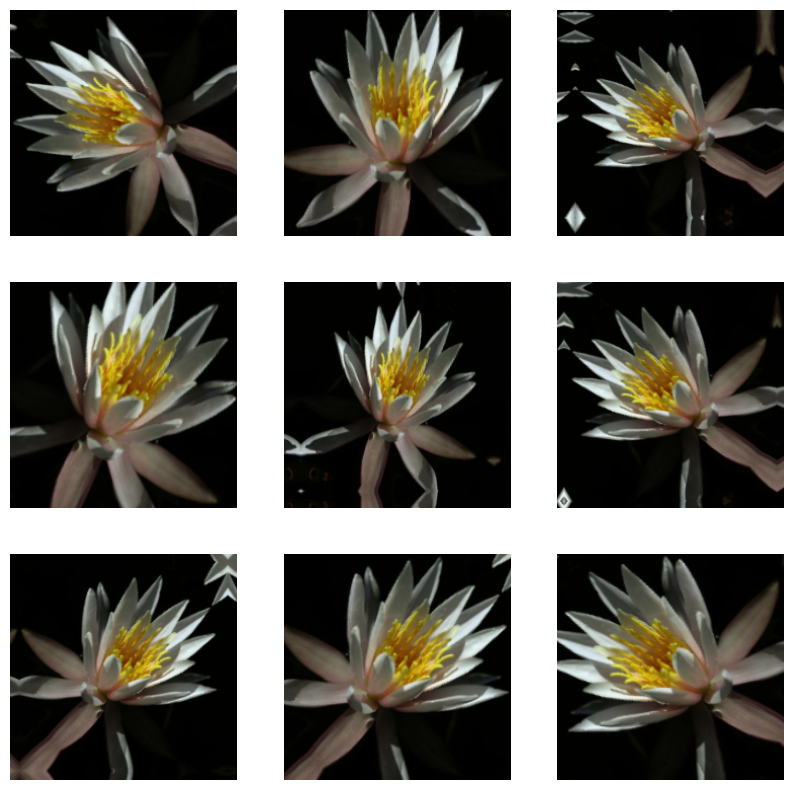

Sample augmented images displayed.


In [7]:
# Cell 4: Visualize Augmented Images (Optional)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        # De-normalize for visualization if using MobileNetV2 preprocess_input
        plt.imshow(augmented_images[0].numpy() / 2 + 0.5)
        plt.axis("off")
plt.show()

print("Sample augmented images displayed.")

In [8]:
# Cell 5: Build the Model with Transfer Learning

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model to use its pre-trained weights
base_model.trainable = False

# Create a classification head
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(num_classes, activation='softmax') # num_classes from metadata

# Build the full model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x) # Add dropout for regularization
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

print("Model built using MobileNetV2 with transfer learning and data augmentation.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model built using MobileNetV2 with transfer learning and data augmentation.


In [14]:
# Cell 6: Compile and Train the Model

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10 # Using your updated number of epochs

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

print("\nInitial model training complete.")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 0.8804 - val_loss: 0.4686
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.8725 - val_loss: 0.4840
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.8706 - val_loss: 0.4868
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8735 - val_loss: 0.4973
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.8794 - val_loss: 0.4847
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9997 - loss: 0.0035 - val_accuracy: 0.8667 - val_loss: 0.5014
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.9987 - loss: 0.0074 - val_accuracy: 0.8657 - val_loss: 0.5220
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy

In [15]:
# Cell 6.5: Fine-Tune the Model for Higher Accuracy

# --- Unfreeze the top layers of the base model ---
# First, let's make the entire base_model trainable
base_model.trainable = True

# Let's see how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

# We will fine-tune from this layer onwards.
# It's a good practice to not fine-tune the entire network.
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# --- Re-compile the model with a very low learning rate for fine-tuning ---
# Using a lower learning rate is crucial to prevent overfitting and
# destroying the pre-trained weights.
fine_tune_lr = base_learning_rate / 10 # e.g., 0.00001
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=fine_tune_lr),
    metrics=['accuracy']
)

print("\nModel re-compiled for fine-tuning.")
model.summary() # Optional: view the updated trainable parameters

# --- Continue training to fine-tune the model ---
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

print("\n🚀 Starting model fine-tuning...")
history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start where the previous training ended
    validation_data=val_ds
)
print("✅ Fine-tuning complete!")


Number of layers in the base model: 154

Model re-compiled for fine-tuning.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 1,992,102 (7.60 MB)

 Non-trainable params: 396,544 (1.51 MB)


🚀 Starting model fine-tuning...
Epoch 10/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8853 - val_loss: 0.4592
Epoch 11/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8892 - val_loss: 0.4546
Epoch 12/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8912 - val_loss: 0.4512
Epoch 13/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8892 - val_loss: 0.4479
Epoch 14/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8902 - val_loss: 0.4446
Epoch 15/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8912 - val_loss: 0.4408
Epoch 16/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8922 - val_loss: 0.4383
Epoch 17/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accurac

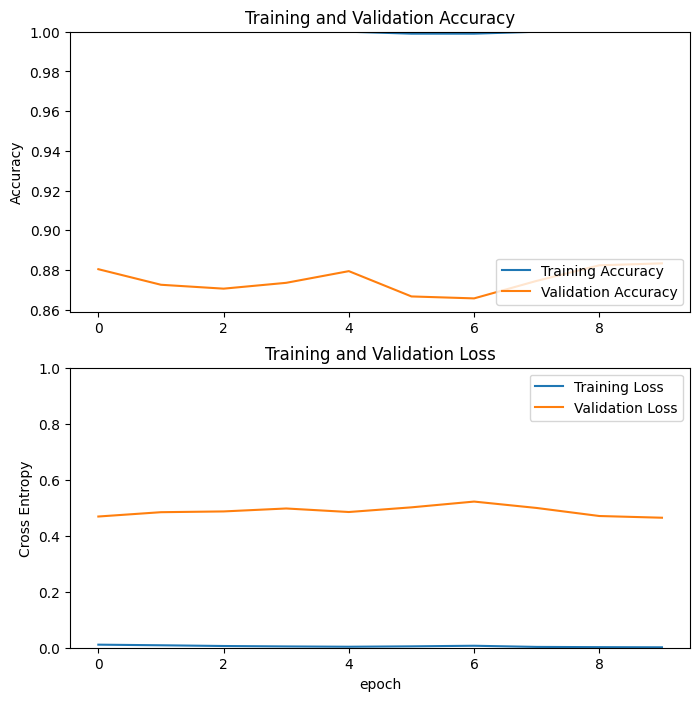

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8840 - loss: 0.4364
Validation Loss: 0.4176
Validation Accuracy: 0.8931


In [16]:
# Cell 7: Evaluate Model Performance

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

/tmp/ipython-input-17-265564852.py:28: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


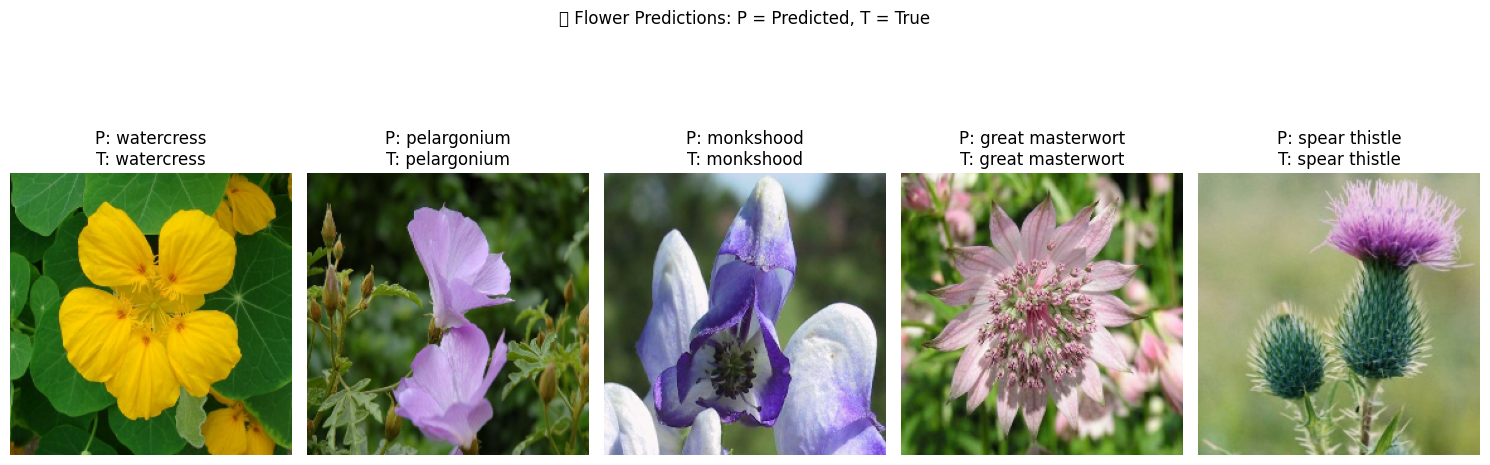

In [17]:
# 🔍 Predict and display 5 flower images from the validation set

class_names = metadata.features['label'].names  # List of flower names

# Get 5 sample images and labels from val_ds
num_images = 5
plt.figure(figsize=(15, 6))

for images, labels in val_ds.take(1):  # Take one batch
    for i in range(num_images):
        image = images[i]
        true_label = labels[i].numpy()

        # Prepare input
        input_tensor = tf.expand_dims(image, 0)

        # Predict
        pred_probs = model.predict(input_tensor, verbose=0)
        predicted_class = tf.argmax(pred_probs[0]).numpy()

        # Plot image with predicted and true label
        plt.subplot(1, num_images, i + 1)
        plt.imshow((image.numpy() / 2 + 0.5))  # De-normalize for display
        plt.title(f"P: {class_names[predicted_class]}\nT: {class_names[true_label]}")
        plt.axis("off")

plt.suptitle("🔮 Flower Predictions: P = Predicted, T = True")
plt.tight_layout()
plt.show()


In [18]:
!pip install -q gradio

import gradio as gr
import numpy as np
import tensorflow as tf
from PIL import Image

# --- Important ---
# This code assumes your 'model' is trained and the 'class_names' list
# (from metadata.features['label'].names) is available in your notebook's memory.
# If you get a NameError, please re-run the cells where they were defined.

def classify_flower(image_input):
    """
    Takes a user-uploaded image, preprocesses it exactly like the training data,
    and returns predictions in the correct format for the Gradio interface.
    """
    # 1. Preprocess the Image
    # Resize to the same size used for training (224x224)
    img = image_input.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Use the *exact same* preprocessing function as in Cell 2
    # This scales pixel values to the [-1, 1] range for MobileNetV2
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Add a batch dimension because the model expects it
    img_array = np.expand_dims(img_array, axis=0)

    # 2. Make a Prediction
    prediction_probs = model.predict(img_array)

    # 3. Format the Output for Gradio
    # Create a dictionary of {class_name: probability} for all classes
    # This format is required for the gr.Label component
    confidences = {class_names[i]: float(prediction_probs[0][i]) for i in range(len(class_names))}

    return confidences

# --- Create and Launch the Gradio Interface ---
gr.Interface(
    fn=classify_flower,
    inputs=gr.Image(type="pil", label="Upload a Flower Image"),
    outputs=gr.Label(num_top_classes=5, label="Top 5 Predictions"),
    title="🌺 Flower Recognition 🌺",
    description="Upload an image of a flower to classify it using the trained MobileNetV2 model. The top 5 most likely flower types will be displayed with their confidence scores.",
    allow_flagging="never"
).launch()


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://72908429e8ff98e452.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
